In [1]:
%matplotlib inline

In [2]:
from fastai.audio import *

In [3]:
torch.cuda.set_device(1)

In [4]:
sg_cfg= SpectrogramConfig(hop=80, n_mels=80, n_fft=480, top_db=80, f_min=20.0, f_max=16000)
config_split= AudioConfig(resample_to = 8000, sg_cfg=sg_cfg, duration=10000, pad_mode='zeros-after')

In [5]:
train_df = pd.read_csv(Path("./data/train.tsv"),sep="\t")

In [6]:
class ImageAudioList(AudioList):
    _bunch = ImageDataBunch
    context = 5
    def reconstruct(self, x): return Image(torch.stack([i[:,self.context+1] for i in x],dim=1).unsqueeze(0))
    
    def show_xys(self, xs, ys)->None:
        items = [[x,y] for i, (x,y) in enumerate(zip(xs,ys))]
        for item in items:
            display(*item)

In [7]:
# class DeepSpeechAudioList(AudioList):
#     _bunch = ImageDataBunch
#     def __init__(self, items, path, config=AudioConfig(), context=5, **kwargs):
#         super().__init__(items=items, path=path, config=config, **kwargs)
#         self.context = context
        
#     def get(self,i):
#         one_spectro = super().get(i).spectro
#         one_spectro = F.pad(one_spectro, pad=(self.context,self.context))
#         return torch.stack([one_spectro[:,:,i:i+(self.context*2+1)].squeeze() for i in range(one_spectro.shape[-1]-(self.context*2))])
    
#     def reconstruct(self, x): return Image(torch.stack([i[:,self.context+1] for i in x],dim=1).unsqueeze(0))
    
#     def show_xys(self, xs, ys)->None:
#         items = [[x,y] for i, (x,y) in enumerate(zip(xs,ys))]
#         for item in items:
#             display(*item)

In [8]:
class SentenceCharList(ItemList):
    
    itoc = list("abcdefghijklmnopqrstuvwxyz '")+['']
    ctoi = defaultdict(lambda: 28)
    def __init__(self, items, path, **kwargs):
        super().__init__(items, **kwargs)
        for i,char in enumerate(self.itoc):
            self.ctoi[char]=i
        
    def get(self,i):
        return F.pad(torch.tensor([self.ctoi[j] for j in self.items[i].lower()]), pad=(0,200), mode='constant', value=28)[:100]

    def reconstruct(self, t:Tensor):
        return "".join((self.itoc[c] for c in t[0]))

In [9]:
#My solution to having to look through training files to make sure they are in training and not validation. 
train_file = defaultdict(bool)
for i in train_df.path:
    train_file[i] = True

In [10]:
def _slice_context(b, context):
    x,y = b
    input_lengths = []
    for input_line in x.sum(dim=2).flip(2,):
        count=0
        total_length = input_line[0].shape[0]
        for elem in input_line[0]:
            if elem != 0.0000:
                break;
            count+=1
        input_lengths.append(total_length-count)
    input_lengths = torch.tensor(input_lengths)
    x = F.pad(x, pad=(context,context))
    x = torch.stack([x[:,:,:,i:i+(context*2+1)] for i in range(x.shape[-1]-(context*2))],dim=2).squeeze()
    return x,(y,input_lengths)

In [11]:
data = (ImageAudioList.from_folder("data/clips", config=config_split)
        .use_partial_data(0.005, seed=42)
        .filter_by_func(lambda x: train_file[x.name])
        .split_by_rand_pct(0.25, seed=42)
        .label_from_func(lambda x: train_df[train_df.path==str(x).split("/")[-1]]["sentence"].iloc[0], label_cls=SentenceCharList)
        .databunch(bs=32)
        .normalize()
       )

Preprocessing: Resampling to 8000


Preprocessing: Resampling to 8000


In [12]:
data.add_tfm(partial(_slice_context, context=5))

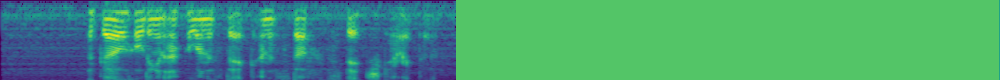

'a girl holding a apple on a stick and a stuff stitch character'

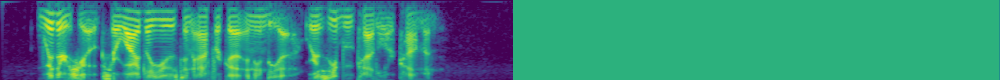

'withers yokes are widely used in africa and india where zebu cattle are common'

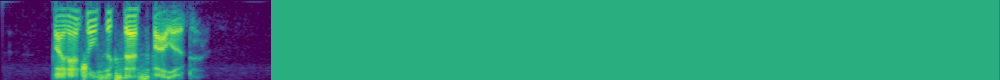

'financial success followed'

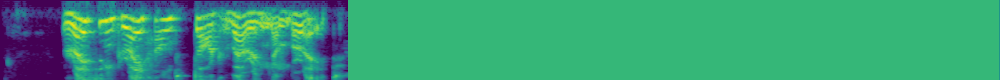

'racing greyhound dog wearing number '

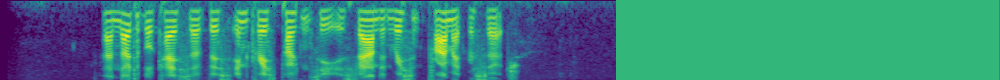

'a notable case of this increased potency is found in recent primate research'

In [13]:
data.show_batch()

In [14]:
class DeepSpeech(nn.Module):
    def __init__(self, context=5, bs=64):
        super(DeepSpeech, self).__init__()
        self.bs = bs
        self.context = context
        self.flatten = nn.Flatten()#lambda x: torch.reshape(x,(-1,1,2432))
        self.h1 = nn.Linear(80*2*self.context+80,2048)
        self.h2 = nn.Linear(2048,2048)
        self.h3 = nn.Linear(2048,2048)
        #self.h4 = nn.LSTM(2048,2048,bidirectional=True,batch_first=True)
        self.h4 = nn.RNN(2048,2048, nonlinearity="relu",bidirectional=True)
        self.h5 = nn.Linear(2048,29) #ct ∈ {a,b,c, . . . , z, space, apostrophe, blank}
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, x):
        x = x.view(x.shape[0],-1,80*2*self.context+80)
        x = self.h1(x).clamp(min=0, max=20)
        x = self.h2(x).clamp(min=0, max=20)
        x = self.h3(x).clamp(min=0, max=20)
        x,h = self.h4(x)
        x = x.view(-1,1000,2,2048)
        x = x.sum(dim=2)
        x = self.h5(x).clamp(min=0, max=20)
        x = self.softmax(x)
        x = x.permute(1,0,2)
        return x

In [15]:
# def ctc_loss(input, target, bs=64, blank=28):
#     r"""Loss function that makes CTC Loss easier to use especially for putting into a fastai Learner"""
#     i_length = torch.tensor([sum([1 for i in t.sum(1) if i != 0]) for t in input])
#     input = input.permute(1,0,2).detach().requires_grad_()
#     ctc = nn.CTCLoss(blank=blank, zero_infinity=True, reduction="sum")
#     t_length = torch.tensor([sum([1 for i in t if i != blank])for t in target])
#     ret = ctc(input, target, input_lengths=i_length, target_lengths=t_length)#torch.tensor([100]*input.size(1)))
#     return ret

In [16]:
#def calculate_sizes(x):
#    return x.shape[1] - (x.argmax(dim=2) == 28).sum(dim=1) - 1
    
def calculate_sizes(x):
    return x.shape[0] - (x.argmax(dim=2)==28).sum(axis=0)
#     input_lengths = []
#     for input_line in x.argmax(dim=2).flip(1,)==x.argmax(dim=2).flip(1,)[:,0][:,None]:
#         count=0
#         total_length = input_line.shape[0]
#         for elem in input_line:
#             if not elem:
#                 break;
#             count+=1
#         input_lengths.append(total_length-count)
    
#     return torch.tensor(input_lengths)
    
def ctc_loss(log_loss, target, i_length, bs=64, blank=28):
    r"""Loss function that makes CTC Loss easier to use especially for putting into a fastai Learner"""
    #i_length = torch.tensor([sum([1 for i in t.sum(1) if i != 0]) for t in input])
    i_length = i_length.long()
    ctc = nn.CTCLoss(blank=blank, zero_infinity=True, reduction="sum")
    t_length = target.shape[-1]-(target==28).sum(dim=1).long()
    target = target.long()
    #t_length = torch.tensor([sum([1 for i in t if i != blank])for t in target])
    ret = ctc(log_loss, target, input_lengths=i_length, target_lengths=t_length)
    #ret = F.ctc_loss(log_loss, target, input_lengths=i_length, target_lengths=t_length, blank=blank, reduction="sum", zero_infinity=True)
    return ret

In [17]:
model = DeepSpeech(context=data.x.context, bs=data.batch_size)

In [18]:
apply_init(model, nn.init.kaiming_normal_)

In [19]:
learn = Learner(data, model, loss_func=partial(ctc_loss,bs=data.batch_size))

In [20]:
#learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


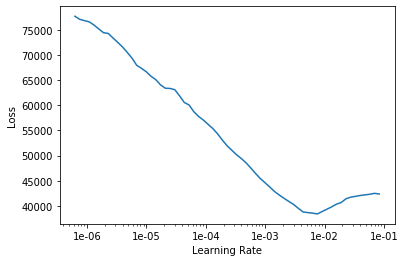

In [21]:
learn.lr_find();learn.recorder.plot()

In [22]:
learn.fit_one_cycle(5,5e-4)

epoch,train_loss,valid_loss,time
0,59078.195312,24929.984375,00:04
1,36772.480469,8058.370117,00:04
2,26070.236328,7756.488281,00:04
3,20588.046875,7565.427734,00:04
4,17253.093750,7462.710449,00:04


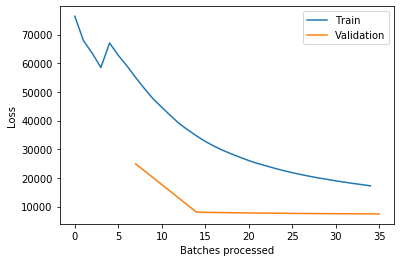

In [23]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


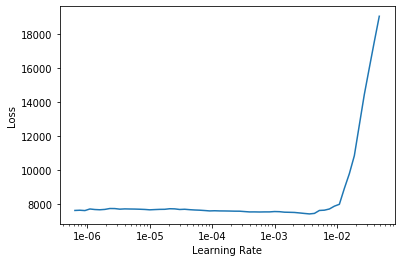

In [28]:
learn.lr_find();learn.recorder.plot()

In [29]:
learn.fit_one_cycle(5,5e-4)

epoch,train_loss,valid_loss,time
0,7645.642090,6882.833984,00:04
1,7562.612793,6977.346191,00:04
2,7454.768555,7037.043457,00:04
3,7329.051270,6604.483398,00:05
4,7221.181152,6563.030273,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


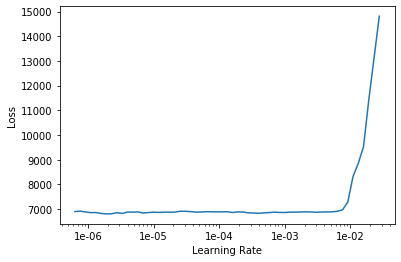

In [30]:
learn.lr_find();learn.recorder.plot()

In [31]:
learn.fit_one_cycle(5,7e-4)

epoch,train_loss,valid_loss,time
0,6893.561035,6567.547852,00:04
1,6877.097168,6423.842773,00:04
2,6786.013672,6450.799316,00:04
3,6759.582520,6438.253906,00:04
4,6729.702637,6383.029297,00:04


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


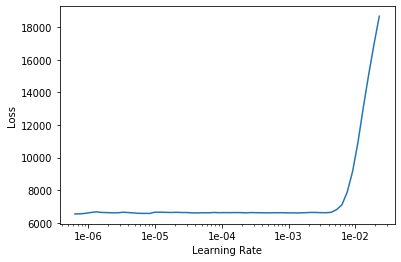

In [36]:
learn.lr_find();learn.recorder.plot()

In [37]:
learn.fit_one_cycle(5,7e-4)

epoch,train_loss,valid_loss,time
0,6598.113770,6392.832031,00:04
1,6623.919922,6366.330078,00:05
2,6677.632812,6400.749023,00:05
3,6661.491211,6417.616699,00:05
4,6611.426270,6351.113770,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


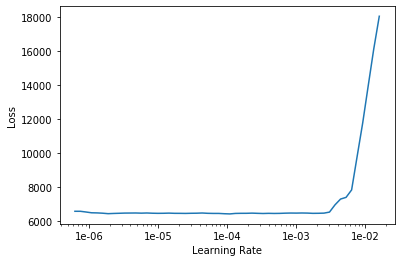

In [42]:
learn.lr_find();learn.recorder.plot()

In [43]:
learn.fit_one_cycle(5,3e-4)

epoch,train_loss,valid_loss,time
0,6480.670410,6378.045410,00:05
1,6465.445801,6335.080566,00:05
2,6444.450684,6312.631348,00:05
3,6420.264648,6386.188965,00:05
4,6403.217285,6375.056152,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


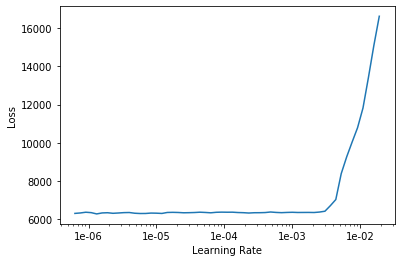

In [48]:
learn.lr_find();learn.recorder.plot()

In [49]:
learn.fit_one_cycle(5,3e-4)

epoch,train_loss,valid_loss,time
0,6328.984863,6291.529785,00:05
1,6347.369629,6534.109375,00:05
2,6321.921387,6281.675293,00:05
3,6293.780762,6226.723633,00:05
4,6250.810059,6228.769043,00:05


In [50]:
inp,targs = next(iter(learn.data.valid_dl))

In [51]:
preds = learn.model(inp)

In [52]:
# Thanks to Lucas (https://colab.research.google.com/drive/1qpyHOM2zonVc84FKRV0lqy-eiWYW2eyl#scrollTo=MsJ8BUhbOXo4) for this piece of code
def ctc_decoder(sequence, eps):
    #Step 1: merge equal stuff
    sequence = sequence.cpu().numpy()
    out = [sequence[0]]
    for item in sequence:
        if item != out[-1]: out.append(item)        
    #Step 2: remove all of the special token (eps)
    out = [p for p in out if p!=eps]
    return out

In [53]:
#data.valid_ds[phrase][0].show()
for phrase in range(32):
    print("".join([learn.data.itoc[i] for i in ctc_decoder(preds.argmax(dim=2)[:,phrase], 28)]))
    print("".join([learn.data.itoc[i] for i in targs[0][phrase]]))

 aie
my jewels are all in their proper places of keeping
       aie
a different thing from boasting of one's triumphs on the wheel
te   e e  aie
he was also appointed the minister of posts and telecommunications in his father's government
   aie
he was succeeded by his eldest son thomas
tie ae te e aie
mammals began a rapid diversification during this period
tie e ee e e aie
the national grasslands visitor center is located in wall
te oe  e aie
there are many fossils to be found buried across the village
  aie
musicians playing in front of a shop
te e   e e e  aie
a postcard was also produced for the town at the time
tae    a   aie
a woman on a cellphone walks up the steps of the underground with another passenger close behind
ae a e    aie
it is built of brick in english bond with sandstone ashlar dressings
te  e ee  e aie
such was the man who had been selected to command our ship
ae      aie
but he held her face firmly and finished his work
tie aie
ambition of the illuminus is a dire